## Group 33

- Alexandre Gonçalves (20240738)
- Bràulio Damba (20240007)
- João Henriques (20240499)
- Mariana Sousa (20240516)
- Victoria Goon (20240550)

### 1 - Mount and Imports

In [ ]:
# source: https://stackoverflow.com/questions/48376580/how-to-read-data-in-google-colab-from-my-google-drive
# This code is required to your Google Drive to the Colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We used the following to extract the  original dataset + dataset obtained after outlier manual removal from a zip file saved in our drive
# The zip file is located in the path "/content/drive/MyDrive/dataset/data.zip"
# source: https://stackoverflow.com/questions/38320290/how-to-extract-zip-file-in-google-colab


import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data.zip" , "r")

zip_ref.extractall("/content/data")

zip_ref.close()

In [3]:
import os
import pandas as pd
import shutil

In [ ]:
# Change the working directory to the correct folder. In the path below, the group member running the code saved the utils.py file and other required folders to run the code

os.chdir('/content/drive/MyDrive/Colab Notebooks')

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


In [5]:
ls

 data.zip                  Library/     'Other Architectures'/
 EDA_Preprocessing.ipynb   model_logs/   VGG16/


In [6]:
from sklearn.model_selection import train_test_split


In [7]:
import numpy as np
from pathlib import Path
from Library.utils import get_callbacks, oversample_adaptive_r5075100
from sklearn.metrics import classification_report

import tensorflow as tf

from keras.utils import image_dataset_from_directory
from keras.applications import ResNet50V2
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, F1Score, Precision, Recall


  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
#from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import Model
from keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Rescaling,
    RandomFlip, RandomRotation, RandomContrast, RandomTranslation
)
from keras.optimizers import Adam
from keras.models import Sequential


#from Library.PreprocessingAugmentTemplate import Preprocessing_Augment_Template

### 2 - Dataset split

In [8]:
from Library.utils import get_all_relative_image_paths
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory
from pathlib import Path

from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, F1Score
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from Library.utils import get_callbacks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [ ]:
# Read metadata from source_images
metadata = pd.read_csv('/content/data/data/original/source_images/metadata.csv')

# Get all relative image paths from images that remained after manual outlier removal
cleaned_unsplit_path = '/content/data/data/outliers_removed_manual/cleaned_unsplit'

# Get all relative image paths from cleaned unsplit directory
relative_paths = get_all_relative_image_paths(cleaned_unsplit_path)

# Create new metadata file after filter from original metadata images removed mannualy
mask = metadata['file_path'].isin(relative_paths)
metadata_outl_manual = metadata[mask]


# Images that remained in cleaned metadata after manual removal of outliers
print(f"Images in cleaned metadata: {len(metadata_outl_manual)}")

Images in cleaned metadata: 10978


In [10]:
# Using stratify to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata_outl_manual, test_size=0.3, stratify=metadata_outl_manual['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)


In [ ]:
# This function is used to move the images to implement the split defined above. After defining what images went to each set, we moved the images to the corresponding folders.

def move_images(df, folder_name, original_base_dir, target_base_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(original_base_dir, row['file_path'])  # e.g., "arthropoda_apidae/image1.jpg"
        subfolder = os.path.dirname(row['file_path'])  # e.g., "arthropoda_apidae"
        dst_dir = os.path.join(target_base_dir, folder_name, subfolder)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Missing file: {src_path}")

In [ ]:
# Set the base directory for the clean unsplit images (inside outliers removed manual folder). 
# Due to limited Google Drive storage for each group member, we couldn't permanently store in the drive the train, val, and test folders.
# As a result, we had to regenerate these datasets every time we ran the code, instead of saving them once for repeated use
original_base_dir = '/content/data/data/outliers_removed_manual/cleaned_unsplit'

# Set the base directory for the destination folders
target_base_dir = '/content/data/data/outliers_removed_manual'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)

In [ ]:
# Create train_oversampled_adaptive_r5075100 directory inside outliers_removed_manual

# Define correct path for the original train data inside the outliers removed manual folder
# Important to define it correctly to avoid data leakage. We can only apply the oversampling to the training set
input_dir = '/content/data/data/outliers_removed_manual/train'

# Define correct path for the output directory to create the oversampled data for the training set
output_dir = '/content/data/data/outliers_removed_manual/train_oversampled_adaptive_r5075100'

# Set the size of the largest class. The value was obtained during the EDA_Preprocessing notebook
max_image_count = 204  

# Call the function oversample_adaptive_r5075100 from the Library.utils to create the oversampled data
oversample_adaptive_r5075100(input_dir, max_image_count, output_dir)

# Time: 13 minutes

### 3 - Training

In [14]:
n_classes = 202

In [ ]:
# Defining some of the parameters used in the model and to load the data
model_name = "ResNet50V2"
epochs = 500
resolution = 224 #Specific for ResNet50V2
batch_size = 64
n_classes = 202
augmentation = False

In [ ]:
# Load the image dataset in the train folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/train_oversampled_adaptive_r5075100"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 17901 files belonging to 202 classes.


In [ ]:
# Load the image dataset in the validation folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

val_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/validation"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1647 files belonging to 202 classes.


In [ ]:
# Load the image dataset in the test folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

test_data = image_dataset_from_directory(
    Path("/content/data/data/outliers_removed_manual/test"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1647 files belonging to 202 classes.


In [ ]:
# Defining the Resnet50V2 model
# THe model design and compilation selected will be be explained in the report but the main structure was inspired by the following paper: https://repositorio.inesctec.pt/server/api/core/bitstreams/a9861ffd-05d8-4af0-b2ce-ec993863fbe2/content
# We decided to use ResNet50V2 during the Model Architecture Selection process since it improves training stability through pre-activation design (compared to ResNetV1) and generalizes well for transfer learning tasks
# Source: https://arxiv.org/abs/1603.05027


def build_ResNet50V2_classifier(input_shape, num_classes, optimizer='adam', metrics=['accuracy']):
    """
    Build a ResNet50V2-based image classification model with integrated data preprocessing and augmentation.

    Parameters:
        input_shape (tuple): Dimensions of input images (height, width, channels).
        num_classes (int): Total number of output classes.
        optimizer (str or keras.optimizers.Optimizer): Optimizer for training.
        metrics (list): List of evaluation metrics.

    Returns:
        keras.Model: Compiled image classification model.
    """

    # Define preprocessing + augmentation pipeline
    preprocess_block = Sequential(name="augmentation_pipeline")
    preprocess_block.add(Rescaling(1./255))
    # preprocess_block.add(RandomFlip("horizontal_and_vertical"))
    # preprocess_block.add(RandomRotation(0.15))
    # preprocess_block.add(RandomContrast(0.2))
    # preprocess_block.add(RandomTranslation(0.1, 0.1))

    # Define input layer
    input_tensor = Input(shape=input_shape, name="input_image")
    x = preprocess_block(input_tensor)

    # Load pre-trained ResNet50V2 base (no top)
    vgg_base = ResNet50V2(include_top=False, weights='imagenet', input_tensor=x)
    vgg_base.trainable = False  # Freeze feature extractor

    # Add classifier head
    x = GlobalAveragePooling2D()(vgg_base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_tensor = Dense(num_classes, activation='softmax', name="output_probs")(x)

    # Compile final model
    model = Model(inputs=input_tensor, outputs=output_tensor, name="ResNet50V2_Classifier")
    model.compile(
        optimizer=optimizer if isinstance(optimizer, str) else Adam(),
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

In [ ]:
# Selection of metrics to evaluate the model performance
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score, Precision(), Recall()]

# callbacks being used to monitor the model performance during training using the utils.py in the Library folder
callbacks = get_callbacks(
    base_dir="model_logs/",
    model_name = "ResNet50V2_NoAug_WithoutOutliers_WithOversamplying"
)

In [ ]:
# Define the optimizer, loss function and the model to run
optimizer = Adam(learning_rate=0.001, name="optimizer")

model = build_ResNet50V2_classifier(input_shape = (resolution,resolution,3), num_classes = n_classes, optimizer=optimizer, metrics=metrics)

#loss = CategoricalCrossentropy(name="loss")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Obtain the model summary
# The model summary is useful to understand the model architecture
# source: https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters 
# source: https://keras.io/api/models/model/

model.summary()

Model: "ResNet50V2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_pipel… │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ augmentation_pip… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 24,207,050 (92.34 MB)

 Trainable params: 642,250 (2.45 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Training the model using the fit method
# The fit method is used to train the model on the training data and validate it on the validation data. 
# source: https://keras.io/api/models/model_training_apis/
# source: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


result = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0820 - f1_score: 0.0486 - loss: 4.8109 - precision: 0.5204 - recall: 0.0150
Epoch 1: val_loss improved from inf to 2.44352, saving model to model_logs/DL_ResNet50V2_NoAug_WithoutOutliers_WithOversamplying_checkpoint_20250420_1659.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 85s 234ms/step - accuracy: 0.0823 - f1_score: 0.0489 - loss: 4.8086 - precision: 0.5208 - recall: 0.0151 - val_accuracy: 0.4244 - val_f1_score: 0.2998 - val_loss: 2.4435 - val_precision: 0.8376 - val_recall: 0.1785 - learning_rate: 9.5000e-04
Epoch 2/500
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3240 - f1_score: 0.2757 - loss: 2.8642 - precision: 0.6743 - recall: 0.1669
Epoch 2: val_loss improved from 2.44352 to 2.01753, saving model to model_logs/DL_ResNet50V2_NoAug_WithoutOutliers_WithOversamplying_checkpoint_20250420_1659.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.3242 - f1_score: 0.2760 - loss: 2.8630 - precision: 0.67

In [24]:
# evaluate on the test ds
test_results = model.evaluate(
    test_data,
    return_dict=True,
    verbose=1
)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.5869 - f1_score: 0.4788 - loss: 1.6633 - precision: 0.7908 - recall: 0.4713


In [ ]:
# Classification report to evaluate the model performance with the performance per class and the overall performance
# Tends to give more precise results since it calculates exact metrics on the entire dataset at once (global view) using our manually predicted labels
# source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


y_true = []
y_pred = []
class_names = train_data.class_names

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
             

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Model results

In [27]:
import matplotlib.pyplot as plt

Test Loss: 1.634399175643921
Test Accuracy: 0.5907710790634155


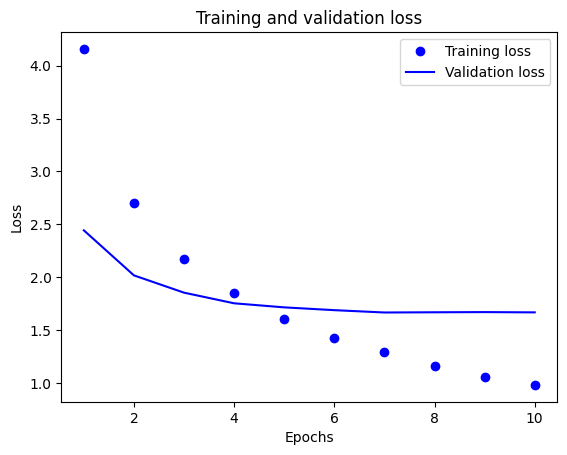

In [ ]:
# Plot that compares the training and validation loss across training epochs
# The plot is useful to understand the model performance and if it is overfitting or underfitting

# Print evaluation results
print("Test Loss:", test_results['loss'])
print("Test Accuracy:", test_results['accuracy'])

# Step 3: Plot the loss
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix to evaluate the model performance. 
# Initially, we considered plotting one matrix per class, but that would be too detailed and hard to read.
# Instead, we opted for a global confusion matrix — a binary summary: "correct" vs "incorrect" predictions.
# This setup merges all classes and treats the problem as binary: 
# - Positive = correct prediction (predicted == true)
# - Negative = incorrect prediction (predicted != true)
# Due to this setup, there are never any "True Negatives" (TN) or "False Positives" (FP), 
# because we only log outcomes when predicted == true (True Positives) or predicted != true (False Negatives).
# Hence, TN and FP are always zero in this matrix.

# Assume y_true and y_pred already contain the true and predicted class indices
# Convert to binary: 1 if correct, 0 if wrong


# Assume y_true and y_pred already contain the true and predicted class indices
# Convert to binary: 1 if correct, 0 if wrong
binary_true = np.ones_like(y_true)  # "truth" is 1 (correct prediction)
binary_pred = (np.array(y_true) == np.array(y_pred)).astype(int)

# Compute confusion matrix
cm = confusion_matrix(binary_true, binary_pred, labels=[1, 0])

# Format into TP, FN, FP, TN
TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

# Print matrix manually like your diagram
print("Confusion Matrix (Correct vs Incorrect):\n")
print(f"               Predicted P    Predicted N")
print(f"True P     {TP:>10}    {FN:>10}")
print(f"True N     {FP:>10}    {TN:>10}")

Confusion Matrix (Correct vs Incorrect):

               Predicted P    Predicted N
True P            973           674
True N              0             0
